In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from skimage.transform import resize
from tqdm.notebook import tqdm 
from keras.utils import to_categorical
from sklearn.utils import compute_class_weight
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from PIL import Image
import tensorflow as tf
import segmentation_models as sm
from keras import backend as K
from segmentation_models.utils import set_trainable
from PIL import Image
import threading
from threading import Thread
# from easyocr import Reader 
from queue import Queue
import time
import pandas as pd

Segmentation Models: using `tf.keras` framework.


In [3]:
tf.config.list_physical_devices('GPU')
tf.device("GPU:0")

In [4]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [41]:
model = tf.keras.models.load_model(r"G:\My Drive\senior\cloud segmentations\cloudSeg_model\model_resnet34_aug_b8_3e-4.h5", custom_objects={"jacard_coef": jacard_coef})

### Predict with real data

In [5]:
import pandas as pd
from tqdm.notebook import tqdm
import albumentations as A

In [43]:
def predict_cc(img_path, model):
    image = cv2.imread(img_path)
    # test_local_img = crop_image2(image)
    test_local_img = cv2.resize(image, (224, 224),0,0, interpolation = cv2.INTER_NEAREST)
    test_local_img = cv2.cvtColor(test_local_img, cv2.COLOR_BGR2RGB)
    test_local_img = test_local_img/255.0
    masked = test_local_img
    local_test_img_input=np.expand_dims(masked, 0)
    prediction_local = (model.predict(local_test_img_input))
    local_predicted_img=np.argmax(prediction_local, axis=3)[0,:,:]
    return local_predicted_img

In [44]:
def estimate_cloudcover(img):
    cloud_pixel = np.sum(np.array(img) == 2)
    undefine_pixel = np.sum(np.array(img) == 0)
    sky_pixel = np.sum(np.array(img) == 1)
    cloud_cover = cloud_pixel/(sky_pixel+cloud_pixel)
    # cloud_cover = cloud_pixel/(sky_pixel-cloud_pixel)
    return cloud_cover

In [45]:
path = "../cloud_dataset2/2021_11_18__08_38_40_HDR_cropped.jpg"

1/1 [==============================] - 1s 1s/step


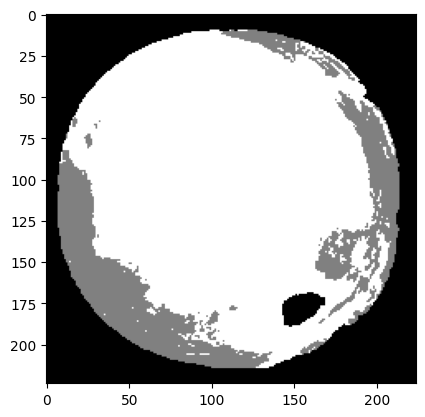

In [46]:
plt.imshow(predict_cc(path, model), cmap="gray")

In [110]:
estimate_cloudcover(predict_cc(path, model))

1/1 [==============================] - 0s 66ms/step


0.7884339606075683

In [22]:
def otsu_mask(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (224,224), interpolation=cv2.INTER_NEAREST)
    r1 = image.shape[1]
    r2 = image.shape[0]

    mask = np.zeros((r2, r1), dtype=np.uint8)

    cv2.circle(mask, (int(r1/2), int(r2/2)), 213, (255, 255, 255), -1, 8, 0)

    masked = cv2.bitwise_and(image, image, mask=mask)
    # plt.imshow(masked)

    ## Find contour of the sun
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_eql = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(img_eql,(5,5),0)

    # Apply a color threshold to segment clear sky 
    _, thresh1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY)
    contours_sky, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(masked, contours_sky, -1, (100, 100, 100), thickness=cv2.FILLED)

    # Apply a color threshold to segment cloud
    _, thresh2 = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)
    contours_cloud, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(masked, contours_cloud, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Apply a color threshold to create a binary image # T = 240 can detect sun light
    _, thresh3 = cv2.threshold(blur, 240, 255, cv2.THRESH_BINARY)
    # Use contour detection to identify the outline of the circle
    contours_sun, _ = cv2.findContours(thresh3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(masked, contours_sun, -1, (0, 0, 0), thickness=cv2.FILLED)
    masked = cv2.cvtColor(masked, cv2.COLOR_RGB2GRAY)
    return masked

def estimate_cloudcover_otsu(img):
    cloud_pixel = np.sum(np.array(img) == 255)
    undefine_pixel = np.sum(np.array(img) == 0)
    sky_pixel = np.sum(np.array(img) == 100)
    cloud_cover = cloud_pixel/(sky_pixel+cloud_pixel)
    # cloud_cover = cloud_pixel/(sky_pixel-cloud_pixel)
    return cloud_cover

In [23]:
img_path= "../cloud_dataset2/"
img_path_list = []
date_list = []
time_list = []
cc_pred = []
for file in tqdm(os.listdir(img_path)):
    if file.endswith(".jpg"):
        filename = os.path.join(img_path, file)
        date = file.split("__")[0]
        time = file.split("__")[1].split("_HDR")[0]
        # img_pred = predict_cc(filename, model)
        img_pred = otsu_mask(filename)
        cc = estimate_cloudcover_otsu(img_pred)
        img_path_list.append(filename)
        date_list.append(date)
        time_list.append(time)
        cc_pred.append(cc)

  0%|          | 0/25198 [00:00<?, ?it/s]

In [24]:
df = pd.DataFrame()
df["date"] = date_list
df["time"] = time_list
df["cloud_cover_pred"] = cc_pred
df["path_list"] = img_path_list

In [25]:
len(df)

25197

In [26]:
df.to_csv("pred2_otsu.csv", index=False)

### linear test

In [27]:
ccdf = pd.read_csv("../Bangkhuntean_CloudCover_2021-16Nov-16Dec (2).csv")
ccdf["Minute"] = ccdf["Minute"].astype(str).str.zfill(2)
ccdf["Second"] = ccdf["Second"].astype(str).str.zfill(2)
ccdf.head()

Year  Month  Day  Hour Minute Second  CloudCover
0  2021     11   16    11     15     59       0.990
1  2021     11   16    11     16     20       0.989
2  2021     11   16    11     16     40       0.989
3  2021     11   16    11     17     01       0.988
4  2021     11   16    11     17     21       0.988

In [28]:
# ccdf["Date"] = ccdf.astype(str).agg(lambda x: f"{x['Year']}-{x['Month']}-{x['Day']}", axis=1)
# ccdf["Time"] = ccdf.astype(str).agg(lambda x: f"{x['Hour']}:{x['Minute']}:{x['Second']}", axis=1)
ccdf["date"] = ccdf["Year"].astype(str) + "-" + ccdf["Month"].astype(str).str.zfill(2) + "-" + ccdf["Day"].astype(str).str.zfill(2)
ccdf["time"] = ccdf["Hour"].astype(str).str.zfill(2) + ":" + ccdf["Minute"].astype(str).str.zfill(2) + ":" + ccdf["Second"].astype(str).str.zfill(2)

In [29]:
ccdf = ccdf.drop(columns=["Year", "Month", "Day", "Hour", "Minute", "Second"])
ccdf.head()

CloudCover        date      time
0       0.990  2021-11-16  11:15:59
1       0.989  2021-11-16  11:16:20
2       0.989  2021-11-16  11:16:40
3       0.988  2021-11-16  11:17:01
4       0.988  2021-11-16  11:17:21

In [30]:
len(ccdf)

22026

In [31]:
pred_df = pd.read_csv("../cloud segmentations/pred2_otsu.csv")
# pred_df = pd.read_csv("../cloud segmentations/pred2_model-cloud-seg-resnet34-aug3-adamw-500-1e_46.csv")
pred_df["date"] = pred_df["date"].str.replace("_","-")
pred_df["time"] = pred_df["time"].str.replace("_",":")
pred_df

date      time  cloud_cover_pred  \
0      2021-11-16  11:15:59          0.520835   
1      2021-11-16  11:16:20          0.517379   
2      2021-11-16  11:16:40          0.519210   
3      2021-11-16  11:17:01          0.521211   
4      2021-11-16  11:17:21          0.522334   
...           ...       ...               ...   
25192  2021-12-16  13:58:00          0.474275   
25193  2021-12-16  13:59:00          0.474660   
25194  2021-12-16  14:00:00          0.475172   
25195  2021-12-16  14:01:00          0.474595   
25196  2021-12-16  14:02:00          0.476453   

                                               path_list  
0      ../cloud_dataset2/2021_11_16__11_15_59_HDR_cro...  
1      ../cloud_dataset2/2021_11_16__11_16_20_HDR_cro...  
2      ../cloud_dataset2/2021_11_16__11_16_40_HDR_cro...  
3      ../cloud_dataset2/2021_11_16__11_17_01_HDR_cro...  
4      ../cloud_dataset2/2021_11_16__11_17_21_HDR_cro...  
...                                                  ...  
25192  ../cloud_dataset2/2021_12_16__13_58_00_HDR_cro...  
25193  ../cloud_dataset2/2021_12_16__13_59_00_HDR_cro...  
25194  ../cloud_dataset2/2021_12_16__14_00_00_HDR_cro...  
25195  ../cloud_dataset2/2021_12_16__14_01_00_HDR_cro...  
25196  ../cloud_dataset2/2021_12_16__14_02_00_HDR_cro...  

[25197 rows x 4 columns]

In [32]:
new_ccdf = pred_df.merge(ccdf,left_on=['date','time'], right_on=['date','time'], how='right')

In [12]:
new_ccdf.to_csv("test_pred.csv",index=False)

In [33]:
len(ccdf)-len(new_ccdf)

0

In [34]:
new_ccdf.isna().sum()

date                0
time                0
cloud_cover_pred    0
path_list           0
CloudCover          0
dtype: int64

In [35]:
len(new_ccdf)

22026

In [36]:
def mean_absolute_percentage_error_keras(y_true, y_pred):

    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))

    return 100. * K.mean(diff, axis=-1)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from math import sqrt

mse = mean_squared_error(new_ccdf['CloudCover'], new_ccdf['cloud_cover_pred'])
mae = mean_absolute_error(new_ccdf['CloudCover'], new_ccdf['cloud_cover_pred'])
mape = mean_absolute_percentage_error_keras(new_ccdf['CloudCover'], new_ccdf['cloud_cover_pred'])
rmse = sqrt(mae)
r2 = r2_score(new_ccdf['CloudCover'], new_ccdf['cloud_cover_pred'])
print("mse:",mse)
print("mae:",mae)
print("mape:",mape.numpy())
print("rmse:",rmse)
print("r2:",r2)

mse: 0.11590836978111657
mae: 0.2919563156999936
mape: 64321.11127884082
rmse: 0.5403298212203298
r2: -0.08268805203241669


### Plot image to show in latex

In [6]:
unet = tf.keras.models.load_model(r"G:\My Drive\senior\cloud segmentations\cloudSeg_model\u-net_noAug-adw-60-1e-4.h5", custom_objects={"jacard_coef": jacard_coef})
unetA = tf.keras.models.load_model(r"G:\My Drive\senior\cloud segmentations\cloudSeg_model\u-net_Aug-adw-60-1e-4.h5", custom_objects={"jacard_coef": jacard_coef})
r34 = tf.keras.models.load_model(r"G:\My Drive\senior\cloud segmentations\cloudSeg_model\restnet34_noAug_b8.h5", custom_objects={"jacard_coef": jacard_coef})
r34A = tf.keras.models.load_model(r"G:\My Drive\senior\cloud segmentations\cloudSeg_model\model_resnet34_aug_b4_3e-4.h5", custom_objects={"jacard_coef": jacard_coef})

In [7]:
def read_img(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img 

In [8]:
def predict_cc(image, model):
    # image = cv2.imread(img_path)
    # test_local_img = crop_image2(image)
    test_local_img = cv2.resize(image, (224, 224),0,0, interpolation = cv2.INTER_NEAREST)
    # test_local_img = cv2.cvtColor(test_local_img, cv2.COLOR_BGR2RGB)
    test_local_img = test_local_img/255.0
    masked = test_local_img
    local_test_img_input=np.expand_dims(masked, 0)
    prediction_local = (model.predict(local_test_img_input))
    local_predicted_img=np.argmax(prediction_local, axis=3)[0,:,:]
    return local_predicted_img

def estimate_cloudcover(img):
    cloud_pixel = np.sum(np.array(img) == 2)
    undefine_pixel = np.sum(np.array(img) == 0)
    sky_pixel = np.sum(np.array(img) == 1)
    cloud_cover = cloud_pixel/(sky_pixel+cloud_pixel)
    # cloud_cover = cloud_pixel/(sky_pixel-cloud_pixel)
    return cloud_cover

In [9]:
image1 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_11_16__11_15_59_HDR_cropped.jpg") # 2021_11_16__11_26_55_HDR_cropped
image2 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_11_16__12_07_37_HDR_cropped.jpg")
image3 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_11_16__12_38_01_HDR_cropped.jpg")
image4 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_11_16__14_09_56_HDR_cropped.jpg")
image5 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_12_16__11_09_00_HDR_cropped.jpg")
image6 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_12_16__10_22_00_HDR_cropped.jpg")
image7 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_11_18__08_38_40_HDR_cropped.jpg")
image_list = [image1,image2,image3,image4,image5,image6,image7]

In [10]:
def plot_img(image):
    original_image = image
    model_1_image = predict_cc(original_image, unet)
    model_2_image = predict_cc(original_image, unetA)
    model_3_image = predict_cc(original_image, r34)
    model_4_image = predict_cc(original_image, r34A)

    # Create a figure with 1 row and 5 columns
    fig, axes = plt.subplots(1, 5)

    # Plot the original image in the first subplot
    axes[0].imshow(original_image)
    axes[0].axis("off")
    axes[0].set_title("Original", fontsize=15)

    # Plot the 4 model images in the remaining subplots
    axes[1].imshow(model_1_image, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title("Unet without\n data augmentation", fontsize=15)

    axes[2].imshow(model_2_image, cmap="gray")
    axes[2].axis("off")
    axes[2].set_title("Unet with\n data augmentation", fontsize=15)

    axes[3].imshow(model_3_image, cmap="gray")
    axes[3].axis("off")
    axes[3].set_title("Unet+ResNet34 without\n data augmentation", fontsize=15)

    axes[4].imshow(model_4_image, cmap="gray")
    axes[4].axis("off")
    axes[4].set_title("Unet+ResNet34 with\n data augmentation", fontsize=15)

    # Change the image size
    fig.set_size_inches(20, 10)

    # Show the figure
    plt.show()

1/1 [==============================] - 1s 1s/step


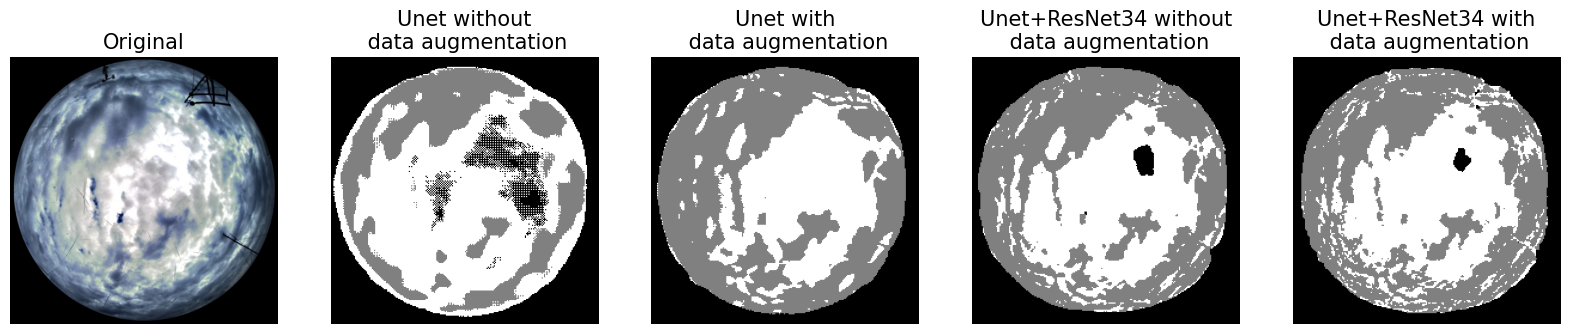

In [11]:
plot_img(image1)

1/1 [==============================] - 0s 40ms/step


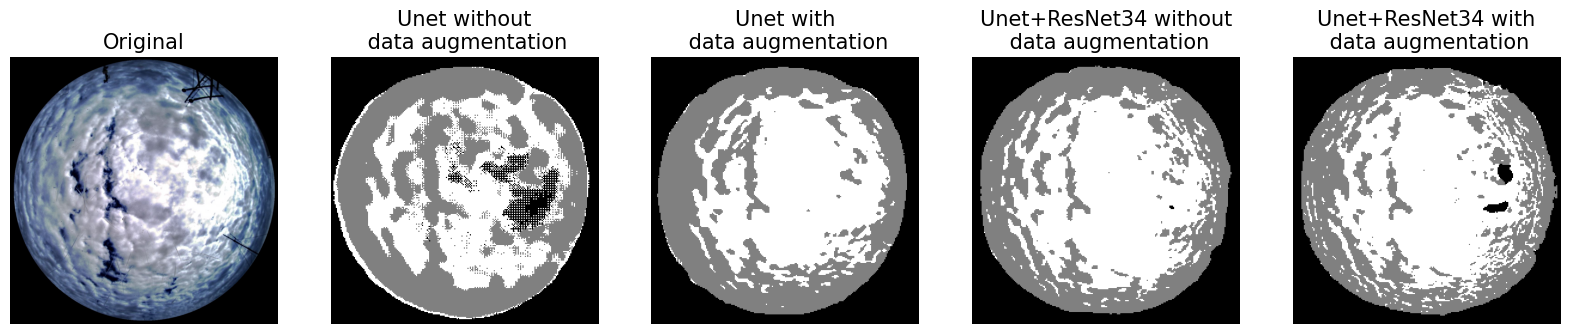

In [12]:
plot_img(image2)

1/1 [==============================] - 0s 32ms/step


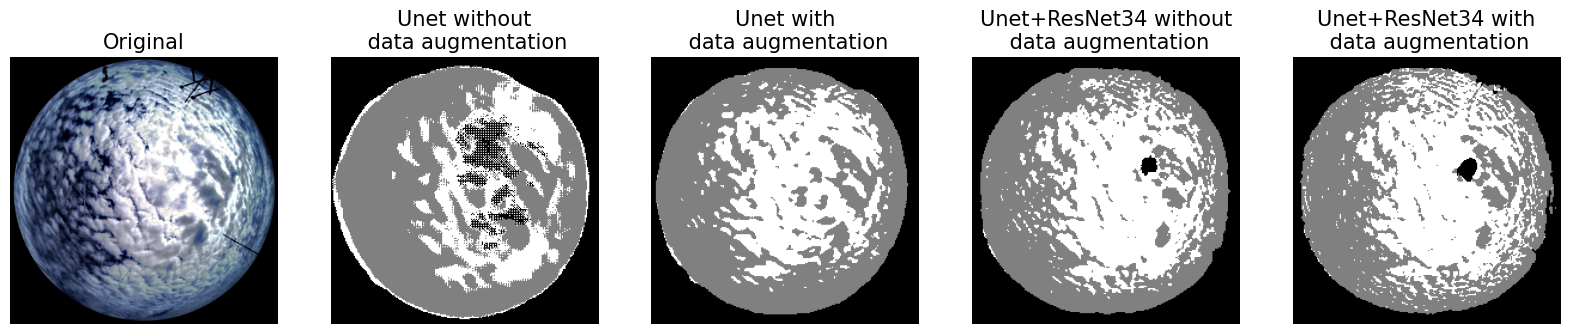

In [13]:
plot_img(image3)

1/1 [==============================] - 0s 33ms/step


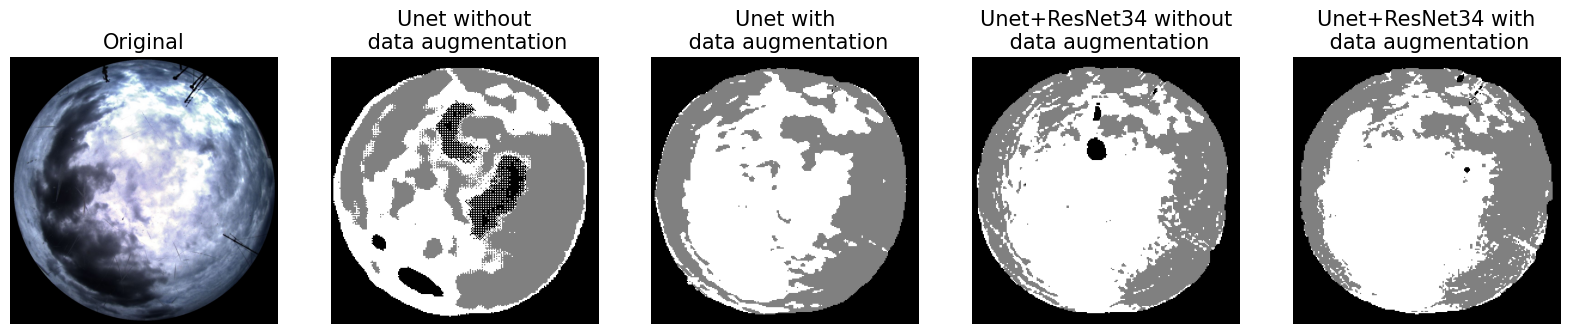

In [14]:
plot_img(image4)

1/1 [==============================] - 0s 35ms/step


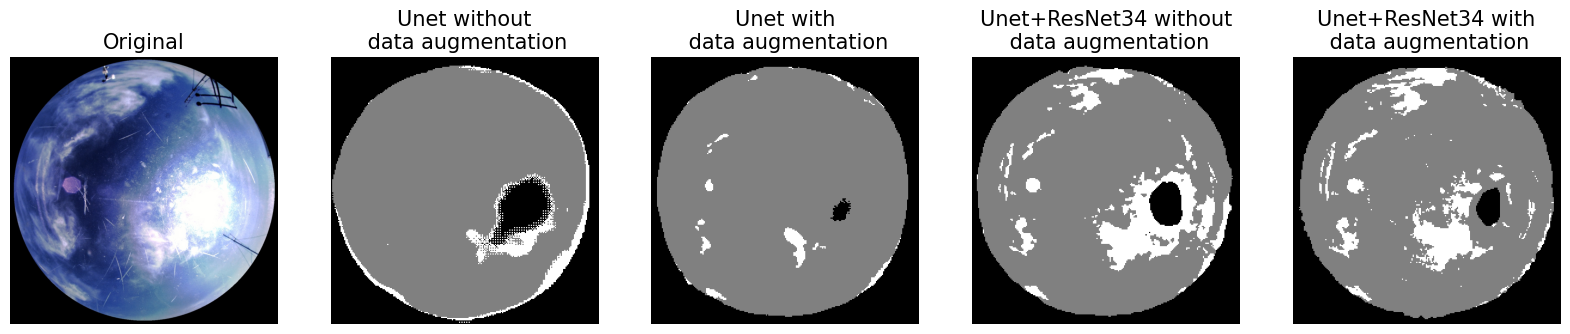

In [15]:
plot_img(image5)

1/1 [==============================] - 0s 38ms/step


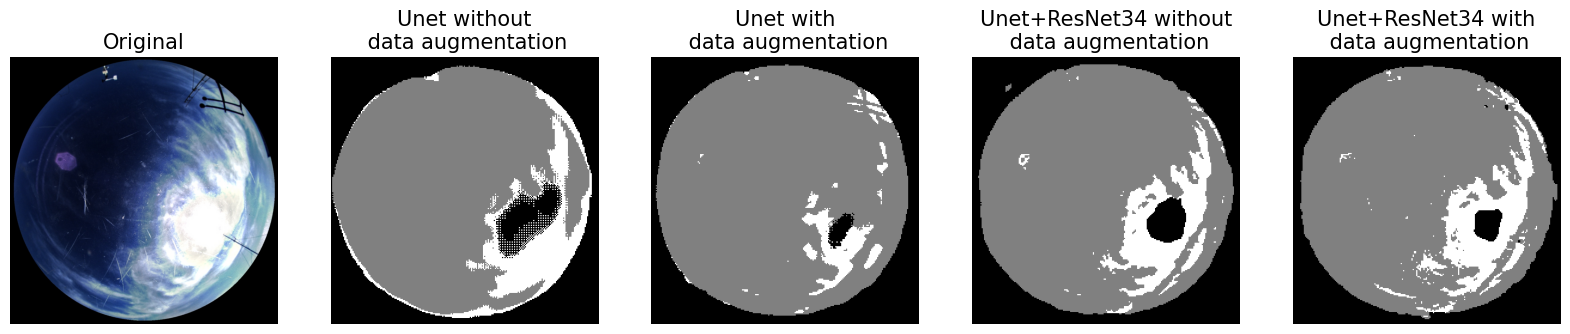

In [16]:
plot_img(image6)

1/1 [==============================] - 0s 39ms/step


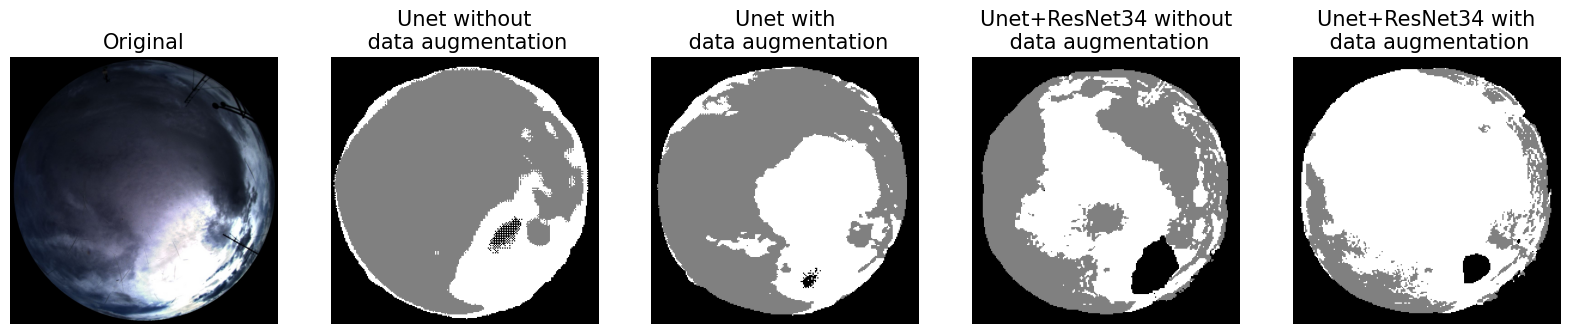

In [17]:
plot_img(image7)

1/1 [==============================] - 0s 31ms/step


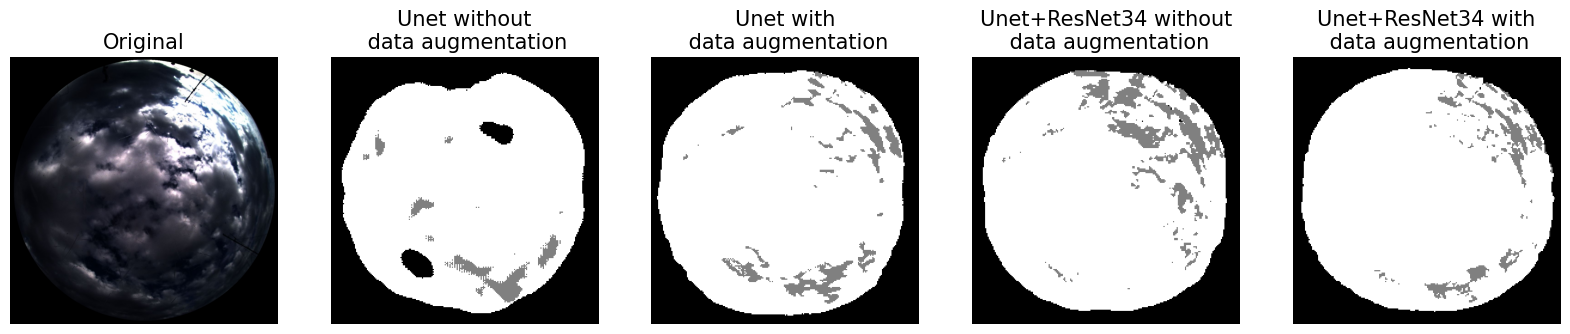

In [18]:
image8 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_11_18__16_11_51_HDR_cropped.jpg")
plot_img(image8)

1/1 [==============================] - 0s 30ms/step


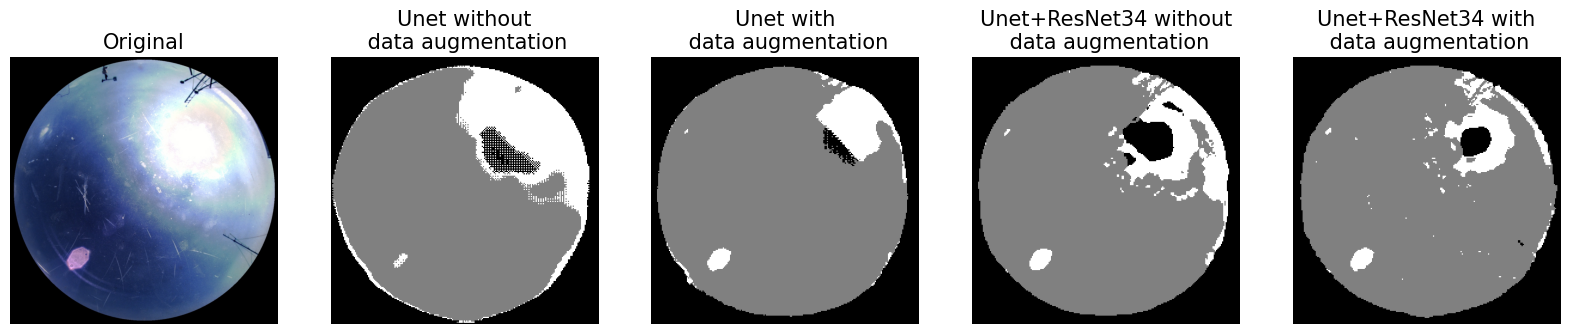

In [19]:
image9 = read_img(r"G:\My Drive\senior\cloud_dataset2\2021_12_16__13_35_00_HDR_cropped.jpg")
plot_img(image9)

### Plot Error Analysis

In [18]:
new_ccdf

date      time  cloud_cover_pred  \
0      2021-11-16  11:15:59          0.471055   
1      2021-11-16  11:16:20          0.474420   
2      2021-11-16  11:16:40          0.472182   
3      2021-11-16  11:17:01          0.488110   
4      2021-11-16  11:17:21          0.485002   
...           ...       ...               ...   
22021  2021-12-16  13:58:00          0.115561   
22022  2021-12-16  13:59:00          0.121245   
22023  2021-12-16  14:00:00          0.124032   
22024  2021-12-16  14:01:00          0.140630   
22025  2021-12-16  14:02:00          0.134846   

                                               path_list  CloudCover  
0      ../cloud_dataset2/2021_11_16__11_15_59_HDR_cro...       0.990  
1      ../cloud_dataset2/2021_11_16__11_16_20_HDR_cro...       0.989  
2      ../cloud_dataset2/2021_11_16__11_16_40_HDR_cro...       0.989  
3      ../cloud_dataset2/2021_11_16__11_17_01_HDR_cro...       0.988  
4      ../cloud_dataset2/2021_11_16__11_17_21_HDR_cro...       0.988  
...                                                  ...         ...  
22021  ../cloud_dataset2/2021_12_16__13_58_00_HDR_cro...       0.168  
22022  ../cloud_dataset2/2021_12_16__13_59_00_HDR_cro...       0.169  
22023  ../cloud_dataset2/2021_12_16__14_00_00_HDR_cro...       0.147  
22024  ../cloud_dataset2/2021_12_16__14_01_00_HDR_cro...       0.145  
22025  ../cloud_dataset2/2021_12_16__14_02_00_HDR_cro...       0.144  

[22026 rows x 5 columns]

In [101]:
new_ccdf["timestamp"] = new_ccdf["date"] + " " +new_ccdf["time"]

In [102]:
new_ccdf

date      time  cloud_cover_pred  \
0      2021-11-16  11:15:59          0.471055   
1      2021-11-16  11:16:20          0.474420   
2      2021-11-16  11:16:40          0.472182   
3      2021-11-16  11:17:01          0.488110   
4      2021-11-16  11:17:21          0.485002   
...           ...       ...               ...   
22021  2021-12-16  13:58:00          0.115561   
22022  2021-12-16  13:59:00          0.121245   
22023  2021-12-16  14:00:00          0.124032   
22024  2021-12-16  14:01:00          0.140630   
22025  2021-12-16  14:02:00          0.134846   

                                               path_list  CloudCover  \
0      ../cloud_dataset2/2021_11_16__11_15_59_HDR_cro...       0.990   
1      ../cloud_dataset2/2021_11_16__11_16_20_HDR_cro...       0.989   
2      ../cloud_dataset2/2021_11_16__11_16_40_HDR_cro...       0.989   
3      ../cloud_dataset2/2021_11_16__11_17_01_HDR_cro...       0.988   
4      ../cloud_dataset2/2021_11_16__11_17_21_HDR_cro...       0.988   
...                                                  ...         ...   
22021  ../cloud_dataset2/2021_12_16__13_58_00_HDR_cro...       0.168   
22022  ../cloud_dataset2/2021_12_16__13_59_00_HDR_cro...       0.169   
22023  ../cloud_dataset2/2021_12_16__14_00_00_HDR_cro...       0.147   
22024  ../cloud_dataset2/2021_12_16__14_01_00_HDR_cro...       0.145   
22025  ../cloud_dataset2/2021_12_16__14_02_00_HDR_cro...       0.144   

                 timestamp  
0      2021-11-16 11:15:59  
1      2021-11-16 11:16:20  
2      2021-11-16 11:16:40  
3      2021-11-16 11:17:01  
4      2021-11-16 11:17:21  
...                    ...  
22021  2021-12-16 13:58:00  
22022  2021-12-16 13:59:00  
22023  2021-12-16 14:00:00  
22024  2021-12-16 14:01:00  
22025  2021-12-16 14:02:00  

[22026 rows x 6 columns]

In [103]:
import plotly.express as px
fig = px.scatter(new_ccdf, x="timestamp", y="cloud_cover_pred")
fig = px.scatter(new_ccdf, x="timestamp", y="CloudCover")
fig.show()

In [20]:
fig = px.scatter(new_ccdf, x="date", y="CloudCover")
fig.show()

In [104]:
new_ccdf

date      time  cloud_cover_pred  \
0      2021-11-16  11:15:59          0.471055   
1      2021-11-16  11:16:20          0.474420   
2      2021-11-16  11:16:40          0.472182   
3      2021-11-16  11:17:01          0.488110   
4      2021-11-16  11:17:21          0.485002   
...           ...       ...               ...   
22021  2021-12-16  13:58:00          0.115561   
22022  2021-12-16  13:59:00          0.121245   
22023  2021-12-16  14:00:00          0.124032   
22024  2021-12-16  14:01:00          0.140630   
22025  2021-12-16  14:02:00          0.134846   

                                               path_list  CloudCover  \
0      ../cloud_dataset2/2021_11_16__11_15_59_HDR_cro...       0.990   
1      ../cloud_dataset2/2021_11_16__11_16_20_HDR_cro...       0.989   
2      ../cloud_dataset2/2021_11_16__11_16_40_HDR_cro...       0.989   
3      ../cloud_dataset2/2021_11_16__11_17_01_HDR_cro...       0.988   
4      ../cloud_dataset2/2021_11_16__11_17_21_HDR_cro...       0.988   
...                                                  ...         ...   
22021  ../cloud_dataset2/2021_12_16__13_58_00_HDR_cro...       0.168   
22022  ../cloud_dataset2/2021_12_16__13_59_00_HDR_cro...       0.169   
22023  ../cloud_dataset2/2021_12_16__14_00_00_HDR_cro...       0.147   
22024  ../cloud_dataset2/2021_12_16__14_01_00_HDR_cro...       0.145   
22025  ../cloud_dataset2/2021_12_16__14_02_00_HDR_cro...       0.144   

                 timestamp  
0      2021-11-16 11:15:59  
1      2021-11-16 11:16:20  
2      2021-11-16 11:16:40  
3      2021-11-16 11:17:01  
4      2021-11-16 11:17:21  
...                    ...  
22021  2021-12-16 13:58:00  
22022  2021-12-16 13:59:00  
22023  2021-12-16 14:00:00  
22024  2021-12-16 14:01:00  
22025  2021-12-16 14:02:00  

[22026 rows x 6 columns]

In [106]:
import plotly.graph_objects as go
fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=new_ccdf.timestamp,
    y=new_ccdf['CloudCover'],
    hovertext=new_ccdf['CloudCover'],
    hoverinfo="text",
    # mode='markers',
    marker=dict(
        color="blue"
        # opacity=0.7
    ),
    showlegend=True,
    name="Real Value"
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=new_ccdf.timestamp,
    y=new_ccdf['cloud_cover_pred'],
    hovertext=new_ccdf['cloud_cover_pred'],
    hoverinfo="text",
    # mode='markers',
    marker=dict(
        color="green",
        opacity=0.7
    ),
    showlegend=True,
    name="Predicted Value"
))

# add title to figure
fig.update_layout(title="Error Analysis")

fig.show()

### multithreading

In [7]:
def ocr(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[0:60,1910:]

    # r,th = cv2.threshold(img,27,255,cv2.THRESH_BINARY_INV)
    kernel = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 1)
    # plt.imshow(img)
    # plt.show()
    # plt.imshow(dilation)
    reader = Reader(['en'], gpu=True)
    result = reader.readtext(dilation)
    return result[0][1].replace(".",":")

def crop_image2(image):
    # image = cv2.imread(input)
    r1 = image.shape[1]
    r2 = image.shape[0]
    mask = np.zeros((r2, r1), dtype=np.uint8)

    cv2.circle(mask, (int(r1/2), int(r2/2)), 570, (255, 255, 255), -1, 8, 0)

    masked = cv2.bitwise_and(image, image, mask=mask)
    cropped = masked[120:1290, 450:1620]
    return cropped

def predict(img_path):
    image = cv2.imread(img_path)
    test_local_img = crop_image2(image)
    test_local_img = cv2.resize(test_local_img, (224, 224),0,0, interpolation = cv2.INTER_NEAREST)
    test_local_img = cv2.cvtColor(test_local_img, cv2.COLOR_BGR2RGB)
    test_local_img = test_local_img/255.0
    masked = test_local_img
    local_test_img_input=np.expand_dims(masked, 0)
    prediction_local = (model.predict(local_test_img_input))
    local_predicted_img=np.argmax(prediction_local, axis=3)[0,:,:]
    return local_predicted_img

In [8]:
class ThreadWithReturnValue(Thread):
    
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None

    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args,
                                                **self._kwargs)
    def join(self, *args):
        Thread.join(self, *args)
        return self._return

In [ ]:
class ThreadWithReturnValue(Thread):
    
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None

    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args,
                                                **self._kwargs)
    def join(self, *args):
        Thread.join(self, *args)
        return self._return
    
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

cloudEstmodel = tf.keras.models.load_model("webapp/cloudSeg_model/model-cloud-seg-resnet34-aug-adw-60-1e_4.h5", custom_objects={"jacard_coef": jacard_coef})

def getDate(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[0:50,1680:1920]
    kernel = np.ones((2,2),np.uint8)
    dilation_img = cv2.dilate(img,kernel,iterations = 1)
    reader = Reader(['en'], gpu=True)
    result = reader.readtext(dilation_img)
    return result[0][1]

def getTime(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[0:50,1910:]
    _,th = cv2.threshold(img,27,255,cv2.THRESH_BINARY_INV)
    reader = Reader(['en'], gpu=True)
    result = reader.readtext(th)
    return result[0][1].replace(".",":")

def preprocess_img(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255.0
    r1 = image.shape[1]
    r2 = image.shape[0]
    mask = np.zeros((r2, r1), dtype=np.uint8)

    cv2.circle(mask, (int(r1/2), int(r2/2)), 570, (255, 255, 255), -1, 8, 0)

    masked = cv2.bitwise_and(image, image, mask=mask)
    cropped = masked[120:1290, 450:1620]
    img = cv2.resize(cropped, (224,224), interpolation=cv2.INTER_NEAREST)
    return img

def cloud_segmentation(img, cloudEstmodel):
    img = preprocess_img(img)
    input_img = np.expand_dims(img, 0)
    predict_img = (cloudEstmodel.predict(input_img))
    predict_img = np.argmax(predict_img, axis=3)[0,:,:]
    return predict_img

def estimate_cloudcover(img):
    cloud_pixel = np.sum(np.array(img) == 2)
    undefine_pixel = np.sum(np.array(img) == 0)
    sky_pixel = np.sum(np.array(img) == 1)
    cloud_cover = cloud_pixel/(sky_pixel+cloud_pixel)
    return cloud_cover

def upload_flip_image(request):
    try:
        if request.method == 'POST' and request.FILES['image']:
            # Save the original image
            image = request.FILES['image']
            print(image)
            fs = FileSystemStorage(settings.MEDIA_ROOT)
            filename = fs.save(image.name, image)
            image_path = "../testredesign/media/"+filename
            
            q = Queue()
            dt = ThreadWithReturnValue(target=getDate, args=[image_path]) ## ocr date
            tt = ThreadWithReturnValue(target=getTime, args=[image_path]) ## ocr time
            ist = threading.Thread(target=lambda q, arg1: q.put(cloud_segmentation(image_path)), args=(q, image_path))

            dt.start()
            tt.start()
            ist.start()

            # Get date and time from the image
            date_est, time_est = dt.join(), tt.join()

            # Segment the image
            img_seg = q.get() # get image from thread
            
            # Estimate cloud cover
            cloud_cover = estimate_cloudcover(img_seg)
            
            # Save the segmented image
            segmentfilename = f"segment_{filename}"
            plt.axis("off")
            plt.imshow(img_seg, cmap="gray")
            plt.savefig(os.path.join("../testredesign/media/", segmentfilename), bbox_inches='tight', pad_inches=0)
            plt.close()
            
            # Render the preview with links to the original and segment images
            context = {
                'original_image_url': fs.url(filename),
                'segment_image_url': fs.url(segmentfilename),
                'Result' : cloud_cover * 100,
                'Date' : f"Datetime: {date_est} | {time_est}", # date_est.replace("-","_") + "__" + time_est.replace(":","_")
                'date_est':date_est,
                'time_est':time_est,
                'image_path':image_path,
                'segmentfilename':segmentfilename,
                'cloud_cover':cloud_cover
                }
            
            return render(request, 'calculate.html', context)
    except:
        if "inserted" in request.POST:
            date_db = request.POST.get('date')
            time_db = request.POST.get('time')
            image_path = request.POST.get('img_path')
            segmentfilename = request.POST.get('seg_path')
            cloud_cover = request.POST.get('cloud_cover_result')
            db_estCloud = ImageCloudCover.objects.create(
                date=date_db,
                time=time_db,
                image=image_path,
                image_segment=segmentfilename,
                cloud_cover=cloud_cover
            )
            db_estCloud.save()
            return render(request, 'calculate.html', {'message':"Inserted data into database!"})
    
    # Render the form for uploading an image
    return render(request, 'calculate.html')

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


1/1 [==============================] - 0s 55ms/step
07:10:00
DONE t1
DONE t2
3.244797706604004
CPU times: total: 1.22 s
Wall time: 3.26 s


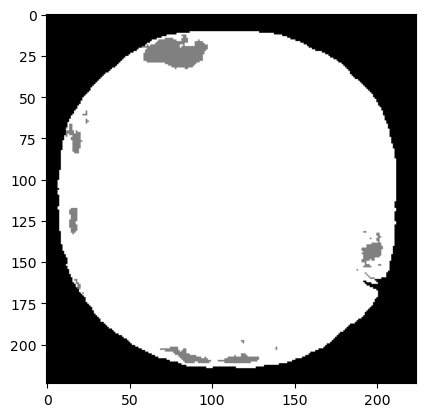

In [15]:
%%time
q = Queue()
image_path = r"D:\2021_bangkhuntian\2021-12-05\2021_12_05__07_10_00_HDR.jpg"
t1 = ThreadWithReturnValue(target=ocr, args=[image_path]) ## ocr
t2 = threading.Thread(target=lambda q, arg1: q.put(predict(image_path)), args=(q, image_path))

t1.start()
t2.start()
start=time.time()
print(t1.join())
print("DONE t1")
# t2.join()
plt.imshow(q.get(), cmap="gray")
print("DONE t2")
end=time.time()
print(end-start)

In [13]:
%%time
image_path = r"D:\2021_bangkhuntian\2021-12-05\2021_12_05__07_10_00_HDR.jpg"
start=time.time()
ocr(image_path)
predict(image_path)
end=time.time()
print(end-start)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


1/1 [==============================] - 0s 53ms/step
3.7628562450408936
CPU times: total: 1.31 s
Wall time: 3.76 s


1/1 [==============================] - 0s 34ms/step
Model inference:  0.08775448799133301


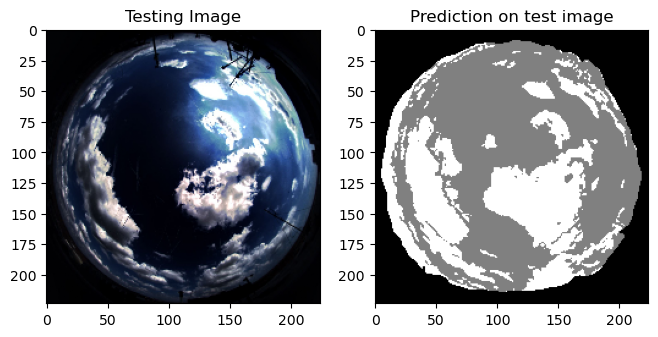

In [7]:
import cv2 
import time

local_path = r"G:\My Drive\senior\cloud segmentations\2021_11_17__13_30_01_crop.jpg"
test_local_img = cv2.imread(local_path)
test_local_img = cv2.resize(test_local_img, (224, 224),0,0, interpolation = cv2.INTER_NEAREST)
test_local_img = cv2.cvtColor(test_local_img, cv2.COLOR_BGR2RGB)
test_local_img = test_local_img/255.0
masked = test_local_img

# plt.imshow(masked)

start_time = time.time()
local_test_img_input=np.expand_dims(masked, 0)
prediction_local = (model.predict(local_test_img_input))
local_predicted_img=np.argmax(prediction_local, axis=3)[0,:,:]
end_time = time.time()
print("Model inference: ",(end_time-start_time))

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(masked)
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(local_predicted_img, cmap="gray")
plt.show()

## INTER_LINEAR, INTER_LINEAR_EXACT, INTER_CUBIC, INTER_LANCZOS4, INTER_NEAREST_EXACT

In [8]:
def estimate_cloudcover(img):
    """
        cloud -> 255 -> 2
        clear sky -> 100 -> 1
        undefine/sun -> 0 -> 0 
    """
    cloud_pixel = np.sum(np.array(img) == 2)
    undefine_pixel = np.sum(np.array(img) == 0)
    sky_pixel = np.sum(np.array(img) == 1)
    print("cloud_pixel", cloud_pixel)
    print("undefine_pixel", undefine_pixel)
    print("sky_pixel", sky_pixel)
    cloud_cover = cloud_pixel/(sky_pixel+cloud_pixel)
    print(cloud_cover*100)

In [9]:
estimate_cloudcover(local_predicted_img)

cloud_pixel 13027
undefine_pixel 15443
sky_pixel 21706
37.506118100941464


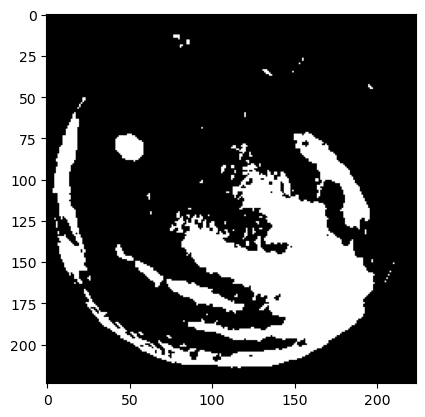

In [11]:
plt.imshow(np.array(local_predicted_img) == 2, cmap='gray')

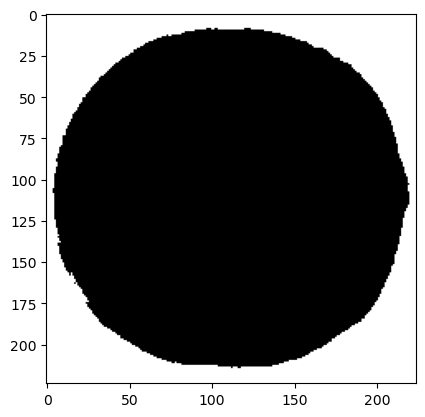

In [9]:
plt.imshow(np.array(local_predicted_img) == 0, cmap='gray')

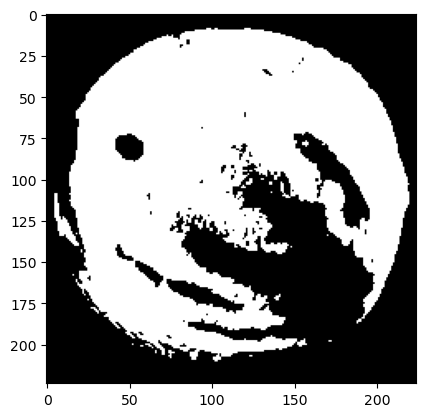

In [10]:
plt.imshow(np.array(local_predicted_img) == 1, cmap='gray')